# **Assignment 20**

# Timeseries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

**Data Preparation and Exploration**

Load the dataset

In [2]:
data = pd.read_csv('exchange_rate.csv', parse_dates=[0])
data.columns = ['date', 'Ex_rate']
data.set_index('date', inplace=True)

 Plot the time series

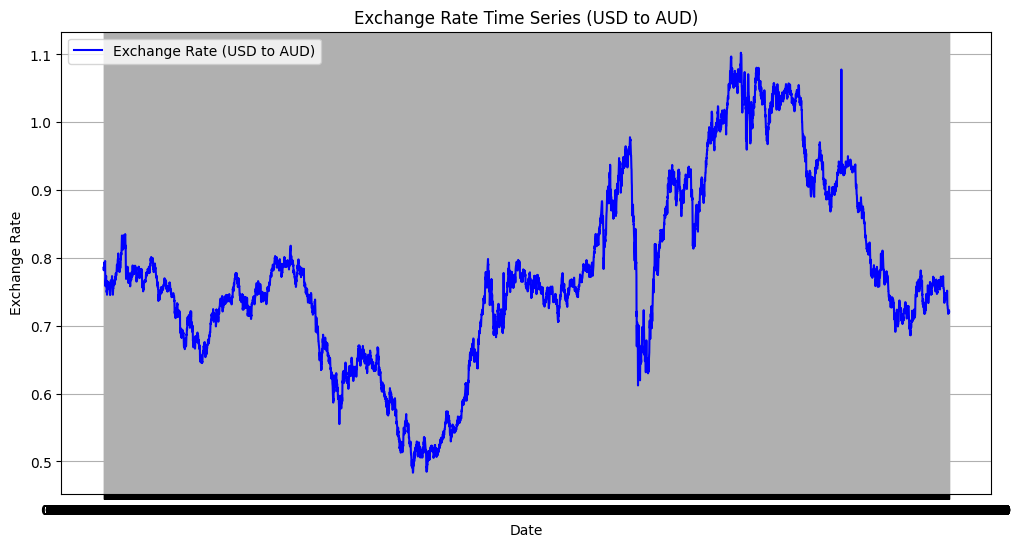

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Ex_rate'], label='Exchange Rate (USD to AUD)', color='blue')
plt.title('Exchange Rate Time Series (USD to AUD)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid()
plt.show()

 Check for missing values

In [4]:
print("Missing values:", data.isnull().sum())

Missing values: Ex_rate    0
dtype: int64


**ARIMA Model**

Stationarity Check

In [5]:
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")

In [6]:
adf_test(data['Ex_rate'])

ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477
Critical Values:
   1%: -3.4312123140180137
   5%: -2.861921078147796
   10%: -2.5669728434336108


Apply first differencing

In [9]:
data['Ex_rate_diff'] = data['Ex_rate'].diff()
data_diff = data.dropna()

In [10]:
data['Ex_rate_diff'] = data['Ex_rate'].diff()
data_diff = data.dropna()
adf_test(data_diff['Ex_rate_diff'])

ADF Statistic: -99.39343120118632
p-value: 0.0
Critical Values:
   1%: -3.4312123140180137
   5%: -2.861921078147796
   10%: -2.5669728434336108


ACF and PACF Plots

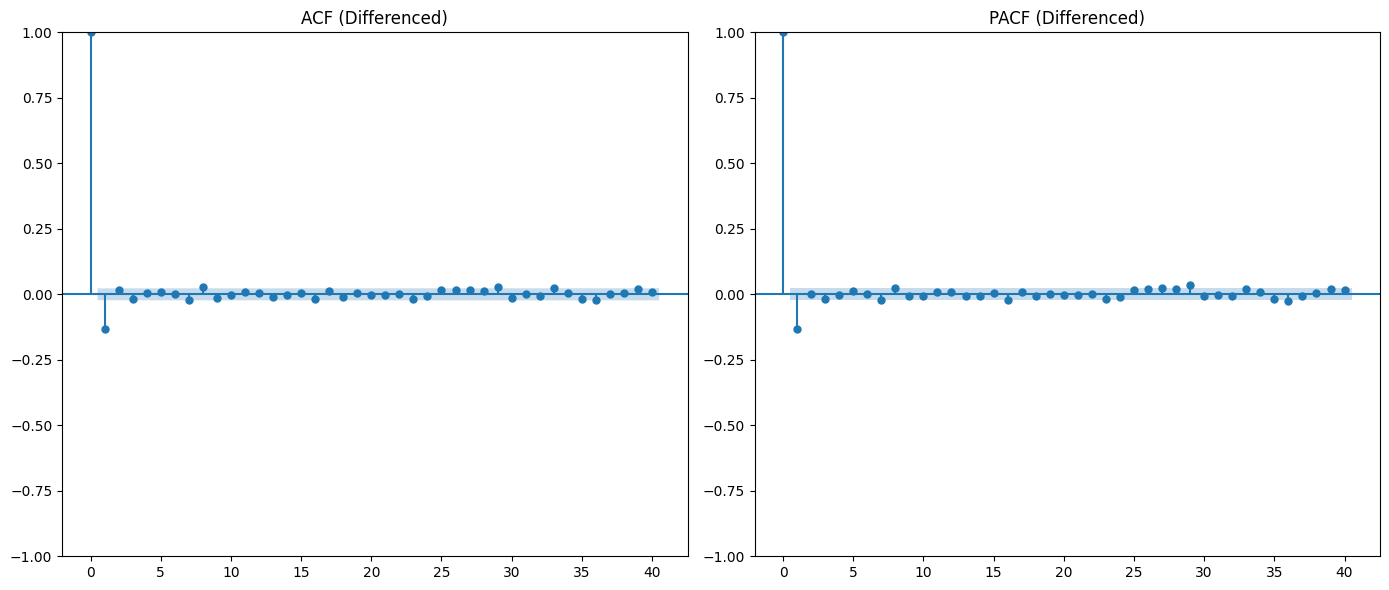

In [12]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(data_diff['Ex_rate_diff'], lags=40, ax=plt.gca(), title='ACF (Differenced)')
plt.subplot(1, 2, 2)
plot_pacf(data_diff['Ex_rate_diff'], lags=40, ax=plt.gca(), title='PACF (Differenced)')
plt.tight_layout()
plt.show()

 Fit ARIMA Model

In [14]:
arima_model = ARIMA(data['Ex_rate'], order=(1, 1, 1))
arima_result = arima_model.fit()
print(arima_result.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Wed, 15 Jan 2025   AIC                         -56102.322
Time:                        08:53:00   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

 Diagnostics

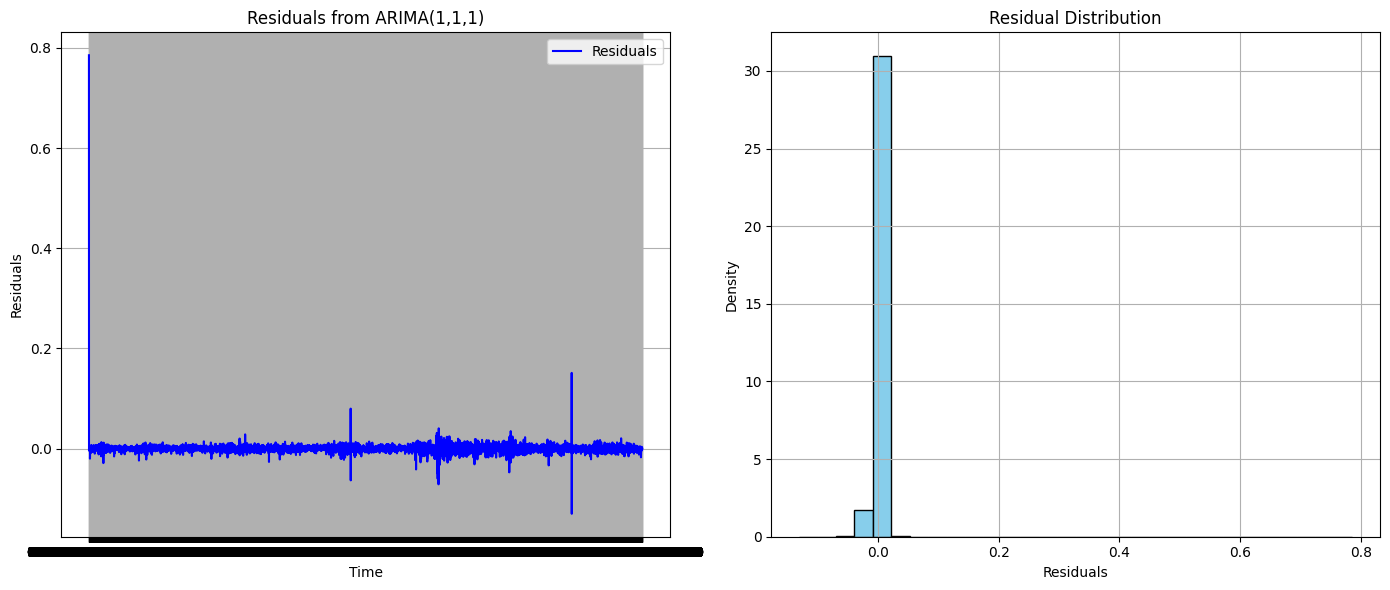

In [15]:
residuals = arima_result.resid
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(residuals, label='Residuals', color='blue')
plt.title('Residuals from ARIMA(1,1,1)')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black', density=True)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid()
plt.tight_layout()
plt.show()

In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

 Forecasting

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-26-675c4abb239f>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(


TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x7bad80a74490>.

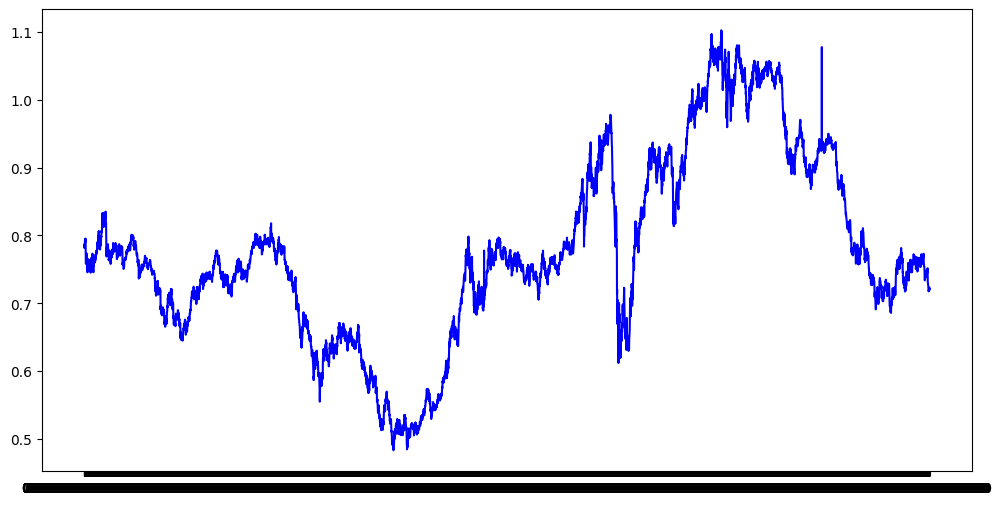

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


forecast_steps = 12
forecast = arima_result.get_forecast(steps=forecast_steps)

forecast_index = pd.date_range(
    start=data.index[-1], periods=forecast_steps + 1, freq="M", tz="UTC"
)[1:]
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(data.index, data["Ex_rate"], label="Actual", color="blue")

plt.plot(
    forecast_index,
    forecast_values,
    label="Forecast",
    color="red",
    linestyle="--",
)
plt.fill_between(
    forecast_index,
    forecast_conf_int.iloc[:, 0],
    forecast_conf_int.iloc[:, 1],
    color="pink",
    alpha=0.3,
    label="Confidence Interval",
)
plt.title("ARIMA(1,1,1) Forecast")
plt.xlabel("Date")
plt.ylabel("Exchange Rate (USD to AUD)")
plt.legend()
plt.grid()
plt.show()

**Exponential Smoothing**

 Fit Holt-Winters Model

In [18]:
hw_model = ExponentialSmoothing(
    data['Ex_rate'],
    trend='add',
    seasonal=None,
    initialization_method='estimated'
).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Forecasting with Holt-Winters

In [21]:
hw_forecast = hw_model.forecast(steps=forecast_steps)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Plot Holt-Winters Forecast

TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x7bad7c9ee500>.

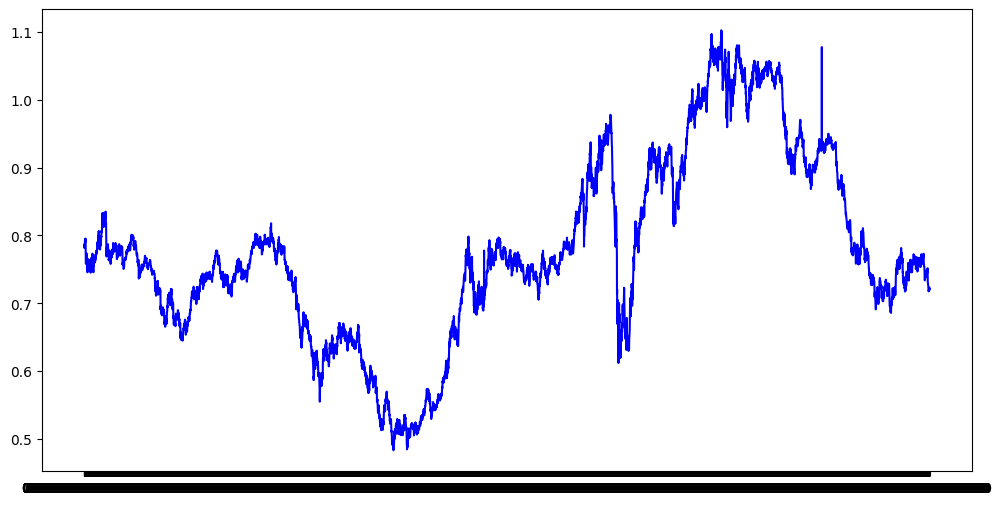

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Ex_rate'], label='Actual', color='blue')
plt.plot(forecast_index, hw_forecast, label='Holt-Winters Forecast', color='green', linestyle='--')
plt.title('Holt-Winters Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (USD to AUD)')
plt.legend()
plt.grid()
plt.show()

**Evaluation and Comparison**

Calculate error metrics

In [23]:
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Error Metrics
arima_mae = mean_absolute_error(data['Ex_rate'][-forecast_steps:], forecast_values)
arima_rmse = np.sqrt(mean_squared_error(data['Ex_rate'][-forecast_steps:], forecast_values))

hw_mae = mean_absolute_error(data['Ex_rate'][-forecast_steps:], hw_forecast)
hw_rmse = np.sqrt(mean_squared_error(data['Ex_rate'][-forecast_steps:], hw_forecast))

print(f"ARIMA MAE: {arima_mae}, RMSE: {arima_rmse}")
print(f"Holt-Winters MAE: {hw_mae}, RMSE: {hw_rmse}")


ARIMA MAE: 0.001664492434046964, RMSE: 0.002000358073456273
Holt-Winters MAE: 0.0016726201414130892, RMSE: 0.001997196833238148
